In [5]:
import sys
print(f"Python version: {sys.version}")


Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [6]:
from nilearn.maskers import MultiNiftiLabelsMasker, NiftiLabelsMasker

# Script to check quality of the data
Includes Timeseries heatmaps, atlas fitting, report saving, GLM building
Support script : ../func.py

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
#import datalad.api as dl
import warnings
import nibabel as nib
warnings.simplefilter('ignore')

#### Load data

In [80]:
nsub = 2

data_dir = '/data/rainville/Hypnosis_ISC/4D_data/full_run'

ana_run = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))[0:nsub]
hyper_run = glob.glob(os.path.join(data_dir, 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub]

subjects = [os.path.basename(os.path.dirname(path)) for path in ana_files][0:nsub]
project_dir = '/data/rainville/dSutterlin/projects/isc_suggestions'
behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
APM_subjects = ['APM' + sub[4:] for sub in subjects][0:nsub] # make APMXX format instead of subXX


In [81]:

ana_run
hyper_run

['/data/rainville/Hypnosis_ISC/4D_data/full_run/sub-38/sub-38_hyperalgesia_run-02_bold_4D.nii.gz',
 '/data/rainville/Hypnosis_ISC/4D_data/full_run/sub-07/sub-07_hyperalgesia_run-02_bold_4D.nii.gz']

Load data

#### **Probabilistic atlas**

(array([ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
        5.        ,  6.00000001,  6.99999999,  8.        ,  9.        ,
       10.        , 11.        , 12.        , 13.        , 14.        ,
       15.        , 16.        , 17.        , 18.00000001, 18.99999999,
       20.        , 21.        , 22.        , 23.        , 24.        ,
       25.        , 26.        , 27.        , 28.        , 29.        ,
       30.        , 31.00000001, 31.99999999, 33.        , 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 41.        , 42.        , 43.00000001, 43.99999999,
       45.        , 46.        , 47.        , 48.        , 49.        ,
       49.99999999]), array([751102,   1746,   2929,   6376,   2952,   2786,   3383,   4862,
         2622,   4809,   1988,   3130,   2629,   1870,   2432,  11709,
         3343,   4017,   2275,   1095,   4350,   3187,   1743,   1250,
         5359,   5557,   5411,   1667,   221

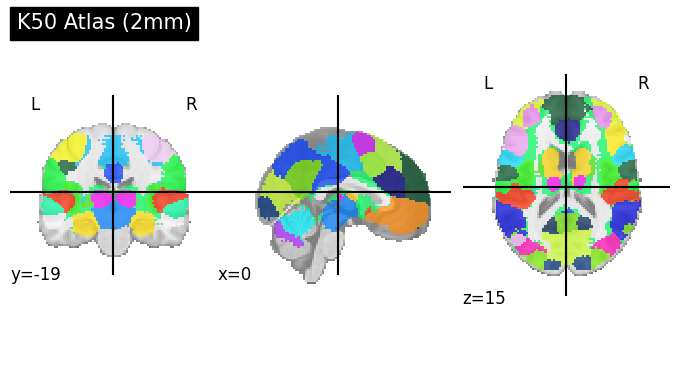

In [82]:
from nilearn.image import load_img
from nilearn.plotting import plot_roi

atlas_path = os.path.join(project_dir, 'masks', 'k50_2mm.nii/', '*.nii')
mask_nifti = load_img(atlas_path)
plot_roi(mask_nifti, title="K50 Atlas (2mm)")
print(np.unique(mask_nifti.get_fdata(), return_counts=True))

##### DiFuMo64

In [84]:
atlas_path = '/data/rainville/dSutterlin/projects/isc_suggestions/DiFuMo256/3mm/maps.nii.gz'
atlas_dict_path = '/data/rainville/dSutterlin/projects/isc_suggestions/DiFuMo256/labels_256_dictionary.csv'
atlas = nib.load(atlas_path)
atlas_df = pd.read_csv(atlas_dict_path)
print('atlas loaded with N ROI : ', atlas.shape)

atlas loaded with N ROI :  (104, 123, 104, 256)


## Apply parcellation and plot reports
1) group
2) individual report + ROI x TRs heatmaps

In [85]:
mask_nifti.shape

(91, 109, 91, 1)

#### 1) Group masker fitting on atlas

#### Function to fit atlas to data for all subjects, and generate group report

In [86]:
import os
from nilearn.maskers import MultiNiftiLabelsMasker

def generate_multinifti_report(func_list, mask_nifti, project_dir, condition_name="Analgesia"):
    """
    Generate and save a MultiNiftiLabelsMasker report for a given condition.

    Parameters
    ----------
    func_list : list of str
        List of paths to the functional files for the condition.
    mask_nifti : str
        Path to the 4D mask NIfTI file.
    project_dir : str
        Path to the project directory where results will be saved.
    condition_name : str, optional
        Name of the condition (default is "Analgesia").
        This name will be used in folder and report names.

    Returns
    -------
    None
    """
    # Ensure mask_nifti is a valid 4D mask
    assert len(mask_nifti.shape) == 4, "Mask image must be 3D."

    nsub = len(func_list)
    
    # Initialize MultiNiftiLabelsMasker
    multi_masker = MultiNiftiLabelsMasker(mask_nifti, standardize=True, detrend=True)

    # Fit-transform the functional files
    multi_fit = multi_masker.fit_transform(func_list)

    # Create directory for reports
    report_dir = os.path.join(project_dir, 'results/imaging', f'reports_{condition_name}_MultiNiftiLabels_ROI')
    os.makedirs(report_dir, exist_ok=True)

    # Generate and save the report
    report = multi_masker.generate_report()
    report_name = f'MultiLabels_report_{condition_name}_{nsub}-subjects.html'
    report_path = os.path.join(report_dir, report_name)
    report.save_as_html(report_path)

    print(f"Report saved at: {report_path}")


#### Apply group label masker and generate report

In [36]:
generate_multinifti_report(ana_run, mask_nifti, project_dir, condition_name="Analgesia")
generate_multinifti_report(hyper_run, mask_nifti, project_dir, condition_name="Hyperalgesia")


Report saved at: /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/reports_Analgesia_MultiNiftiLabels_ROI/MultiLabels_report_Analgesia.html
Report saved at: /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/reports_Hyperalgesia_MultiNiftiLabels_ROI/MultiLabels_report_Hyperalgesia.html


#### 2) Individual atlas report (label masker)
-->Save ROI x TRs heatmap + individual LabelMasker report in /results/cond/

#### Function to generate individual report and heatmaps of ROI x TRs for each subject. Saves in /results/imaging/

In [43]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.maskers import NiftiLabelsMasker

def generate_individual_labelMasker_reports_heatmap(subjects, func_list, mask_nifti, project_dir, condition_name="Analgesia"):
    """
    Generate and save individual ROI reports and heatmaps for each subject.

    Parameters
    ----------
    func_list : list of str
        List of paths to the functional files for each subject.
    mask_nifti : str
        Path to the 4D mask NIfTI file.
    project_dir : str
        Path to the project directory where results will be saved.
    condition_name : str, optional
        Name of the condition (default is "Analgesia").
        This name will be used in folder and report/heatmap names.

    Returns
    -------
    list of numpy.ndarray
        List of masked timeseries for all subjects.
    """
    # Directory to save individual reports
    report_dir = os.path.join(project_dir, 'results/imaging', f'ROI_reports_{condition_name}')
    os.makedirs(report_dir, exist_ok=True)

    # Initialize NiftiLabelsMasker
    label_masker = NiftiLabelsMasker(mask_nifti, standardize=True, detrend=True)

    # Storage for masked timeseries
    masked_timeseries = []

    for i, file in enumerate(func_list):
        sub_id = subjects[i]
        print(f"Processing subject {sub_id}...")
        
        # Extract timeseries for the subject
        ts = label_masker.fit_transform(file)
        masked_timeseries.append(ts)

        # Generate and save the report for this subject
        report = label_masker.generate_report()
        report_path = os.path.join(report_dir, f'ROI_report_{sub_id}_{condition_name}.html')
        report.save_as_html(report_path)

        # Plot heatmap of ROI × TRs
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(ts.T, cmap='coolwarm', cbar=True, ax=ax)
        ax.set_title(f"Subject {i + 1} - Time Series of All ROIs ({condition_name})", fontsize=16)
        ax.set_xlabel('Timepoints', fontsize=12)
        ax.set_ylabel('ROI Index', fontsize=12)
        plt.tight_layout()

        # Save the heatmap
        heatmap_path = os.path.join(report_dir, f'ROI_heatmap_{sub_id}_{condition_name}.png')
        plt.savefig(heatmap_path, dpi=300)
        plt.close()

        print(f"Heatmap saved for {sub_id} at {heatmap_path}")
        print(f"Report saved for {sub_id} at {report_path}")

    return masked_timeseries


#### Generate and save individual report and heatmaps for two runs

In [44]:
masked_timeseries = generate_individual_labelMasker_reports_heatmap(subjects, ana_run, mask_nifti, project_dir, condition_name="Analgesia")

masked_timeseries = generate_individual_labelMasker_reports_heatmap(subjects, hyper_run, mask_nifti, project_dir, condition_name="Hyperalgesia")



Processing subject sub-09...
Heatmap saved for sub-09 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_heatmap_sub-09_Analgesia.png
Report saved for sub-09 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_report_sub-09_Analgesia.html
Processing subject sub-03...
Heatmap saved for sub-03 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_heatmap_sub-03_Analgesia.png
Report saved for sub-03 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_report_sub-03_Analgesia.html
Processing subject sub-09...
Heatmap saved for sub-09 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Hyperalgesia/ROI_heatmap_sub-09_Hyperalgesia.png
Report saved for sub-09 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Hyperalgesia/ROI_report_sub-09_Hyperalgesia.htm

Shock Onsets: [188.723 197.724 203.723 212.723 218.722 224.722 398.721 407.72 413.72
 425.723 431.721 437.719 446.72 452.72 458.718 611.719 623.718 629.717
 638.719 644.717 650.717 815.717 824.716 830.715 842.715 848.717 854.717
 863.717 869.717 875.717 1028.715 1040.715 1046.716 1055.716 1061.714
 1070.714]
Inter-Onset Intervals (IOIs): [9.000999999999976 5.999000000000024 9.0 5.998999999999995 6.0 173.999
 8.999000000000024 6.0 12.002999999999986 5.9979999999999905
 5.9979999999999905 9.001000000000033 6.0 5.9979999999999905
 153.00100000000003 11.99899999999991 5.999000000000024 9.002000000000066
 5.997999999999934 6.0 165.0 8.999000000000024 5.999000000000024 12.0
 6.001999999999953 6.0 9.0 6.0 6.0 152.99799999999993 12.0
 6.000999999999976 9.0 5.998000000000047 9.0]


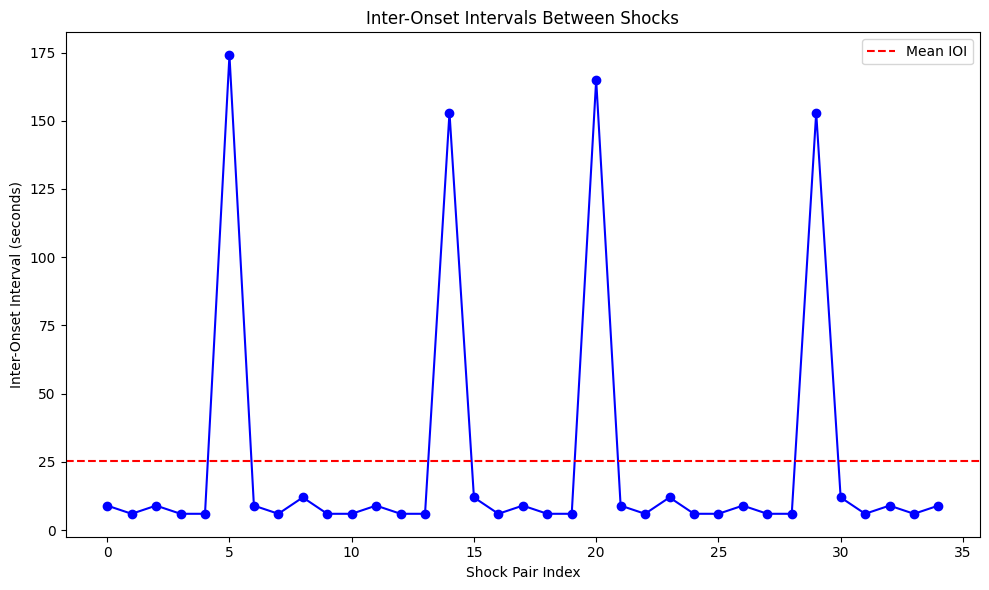

In [87]:
# Assuming 'events' is the DataFrame containing the event file
events = events_ana[0]
shock_events = events[events['trial_type'].str.contains("shock", na=False)]
shock_onsets = shock_events['onset'].values

# Calculate Inter-Onset Intervals (IOIs)
iois = np.diff(shock_onsets)

# Print results
print("Shock Onsets:", shock_onsets)
print("Inter-Onset Intervals (IOIs):", iois)

# Visualize the IOIs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(iois, marker='o', linestyle='-', color='blue')
plt.axhline(y=np.mean(iois), color='red', linestyle='--', label='Mean IOI')
plt.xlabel('Shock Pair Index')
plt.ylabel('Inter-Onset Interval (seconds)')
plt.title('Inter-Onset Intervals Between Shocks')
plt.legend()
plt.tight_layout()
plt.show()


# GLM and data structure

#### Test SPM mat

In [88]:
ls /data/rainville/Hypnosis_ISC/4D_data/sub-06


ls: cannot access '/data/rainville/Hypnosis_ISC/4D_data/sub-06': No such file or directory


#### Import and load data!

In [89]:
events_hyper[0]

,onset,duration,trial_type
0,94,94,N_HYPER1_instrbk_1
3,188.724,0,N_HYPER1_shock_1
4,200.724,0,N_HYPER1_shock_2
5,206.723,0,N_HYPER1_shock_3
6,215.723,0,N_HYPER1_shock_4
7,221.723,0,N_HYPER1_shock_5
8,227.725,0,N_HYPER1_shock_6
21,273,122,HYPER1_instrbk_1
23,395.722,0,HYPER1_shock_1
24,404.721,0,HYPER1_shock_2


In [52]:
mat = '/data/rainville/HYPNOSIS_IMAGING_DATA/GROUP_STATS_JC/002_Analgesia_Instruction/SPM.mat' 

In [71]:
len(design_matrix)

24

In [90]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Explore the structure to find the design matrix
if 'SPM' in spmmat:
    spm = spmmat['SPM']
    xX = spm['xX']  # Design matrix information
    design_matrix = xX['X']  # The design matrix itself
    column_names = xX['name']  # Column names for the design matrix
else:
    raise ValueError("SPM.mat does not contain the 'SPM' variable.")

# Print basic information
print(f"Design matrix shape: {design_matrix.shape}")
print(f"Column names: {column_names}")

# Plot the design matrix
plt.figure(figsize=(12, 6))
sns.heatmap(design_matrix, cmap='coolwarm', cbar=True, xticklabels=column_names, yticklabels=False)
plt.title('SPM Design Matrix')
plt.xlabel('Regressors')
plt.ylabel('Scans (TRs)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Design matrix shape: (24,)
Column names: mean


IndexError: Inconsistent shape between the condition and the input (got (24, 1) and (24,))

<Figure size 1200x600 with 0 Axes>

In [8]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.path.dirname('func.py'), ".."))
sys.path.append(parent_dir)

In [9]:
nsub = 3

data_dir = '/data/rainville/Hypnosis_ISC/4D_data/full_run'

ana_run = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))[0:nsub]
hyper_run = glob.glob(os.path.join(data_dir, 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub]

subjects = [os.path.basename(os.path.dirname(path)) for path in ana_run][0:nsub]
project_dir = '/data/rainville/dSutterlin/projects/isc_suggestions'
behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
APM_subjects = ['APM' + sub[4:] for sub in subjects][0:nsub] # make APMXX format instead of subXX
APM_subjects

['APM38', 'APM07', 'APM42']

#### Extract timestamps/events, movement files based on APM_subjects

In [10]:
import func
import importlib
importlib.reload(func) 

conditions = ['Analgesia', 'Hyperalgesia']
events_dir = '/data/rainville/HYPNOSIS_IMAGING_DATA/timestamps'
confound_dir = '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii'


events_ana =[func.get_timestamps(
                    data_dir, sub, events_dir, conditions[0], return_path=False
                )
              .sort_values(by='onset')
                for sub in APM_subjects
          ]
events_hyper =[func.get_timestamps(
                    data_dir, sub, events_dir, conditions[1], return_path=False
                )
               .sort_values(by='onset')
                for sub in APM_subjects
          ]

#ANA run first!
confound_files=[]
for sub in APM_subjects:
    
    formatted_sub = f"{sub[:3]}_{sub[3:]}*"
    #print(formatted_sub)
    # Extend the confound_files list with the matching files
    confound_files.extend(
        glob.glob(os.path.join(confound_dir, 'H*', '*', formatted_sub, '*_8nuisreg_*'))
    )
    #print(glob.glob(os.path.join(confound_dir, 'H*', '*', formatted_sub, '*_8nuisreg_*')))
print('len confound files : ', len(confound_files))    

cf4 = []  #extra 4 sub with diff TRs in H2/APM*/*nuis.txt
for sub in APM_subjects:
    formatted_sub = f"{sub[:3]}_{sub[3:]}*"
    cf4.extend(
        glob.glob(os.path.join(confound_dir, 'H*', formatted_sub, '*_8nuisreg_*'))
    )
    
print(f'found extra {len(cf4)} condound files')
confound_files.extend(cf4)

# Reorder matching APM_subjects
ordered_confound_files = []
for sub in APM_subjects:
    formatted_sub = f"{sub[:3]}_{sub[3:]}"
    match = [f for f in confound_files if formatted_sub in f]
    if match:
        ordered_confound_files.append(match[0])  # Take the first match

confound_files = ordered_confound_files

print('Total confound files : ', len(confound_files))


len confound files :  3
found extra 0 condound files
Total confound files :  3


Ensure same length and order of all variables

In [11]:
print(len(APM_subjects), len(events_hyper), len(events_ana), len(confound_files))
confound_files

3 3 3 3


['/data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H1/377vol/APM_38_H1/APM38_8nuisreg_concat.txt',
 '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H1/372vol/APM_07_H1/APM07_8nuisreg_concat.txt',
 '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H2/377vol/APM_42_H2/APM42_8nuisreg_concat.txt']

### Check TRs per condition

In [176]:
events_ana[0]


,onset,duration,trial_type
0,94,94,N_ANA1_instrbk_1
3,188.723,0,N_ANA1_shock_1
4,197.724,0,N_ANA1_shock_2
5,203.723,0,N_ANA1_shock_3
6,212.723,0,N_ANA1_shock_4
7,218.722,0,N_ANA1_shock_5
8,224.722,0,N_ANA1_shock_6
21,270,128,ANA1_instrbk_1
23,398.721,0,ANA1_shock_1
24,407.72,0,ANA1_shock_2


#### Function to count TRs for suggestion conditions, for neutral and modulation suggestion. Added to func.py file

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

def count_TRs_2conds_general(
    event_files, 
    TR=3, 
    neutral_pattern="N_ANA.*instrbk", 
    modulation_pattern=r"ANA.*instrbk", 
    title='Neutral and Modulation Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="salmon",
    save_path = False
):
    """
    Counts and compares the total number of TRs for neutral and modulation suggestion blocks across subjects.

    Parameters
    ----------
    event_files : list of pandas.DataFrame
        A list where each element is a DataFrame containing the event file data for one subject.
        Each DataFrame must have columns: 'onset', 'duration', 'trial_type'.

    TR : int, optional
        The TR (Repetition Time) duration in seconds. Default is 3.

    neutral_pattern : str, optional
        Regex pattern to identify neutral suggestion blocks. Default is "N_ANA.*instrbk".

    modulation_pattern : str, optional
        Regex pattern to identify modulation suggestion blocks. Default is "ANA.*instrbk".

    title : str, optional
        The title for the plot. Default is 'Neutral and Modulation Suggestion TRs per Subjects'.

    Returns
    -------
    pd.DataFrame
        A DataFrame summarizing the total TRs for neutral and modulation suggestion blocks for all subjects.

    Notes
    -----
    Neutral and modulation suggestion blocks are identified using provided regex patterns.

    Example
    -------
    TRs_df = count_TRs_2conds_general(
        events_hyper, 
        TR=3, 
        neutral_pattern="N_HYPER.*instrbk", 
        modulation_pattern="HYPER.*instrbk",
        title='Neutral and Hyperalgesia Suggestion TRs per Subjects'
    )
    """

    # Initialize lists to store TR counts for each condition
    neutral_TRs_list = []
    modulation_TRs_list = []

    # Loop through all subjects' event data
    for i, events in enumerate(event_files):
        # Filter for neutral suggestion blocks
        neutral_blocks = events[events['trial_type'].str.contains(neutral_pattern, na=False, regex=True)]
        neutral_durations = neutral_blocks['duration'].tolist()
        neutral_total_duration = sum(neutral_durations)
        neutral_total_TRs = int(neutral_total_duration / TR)
        neutral_TRs_list.append(neutral_total_TRs)

        # Filter for modulation suggestion blocks, excluding the neutral ones
        modulation_blocks = events[
            events['trial_type'].str.contains(modulation_pattern, na=False, regex=True) &
            ~events['trial_type'].str.contains(neutral_pattern, na=False, regex=True)
        ]
        modulation_durations = modulation_blocks['duration'].tolist()
        modulation_total_duration = sum(modulation_durations)
        modulation_total_TRs = int(modulation_total_duration / TR)
        modulation_TRs_list.append(modulation_total_TRs)

    # Create a DataFrame for easier comparison
    TRs_df = pd.DataFrame({
        "Subject": [f"Subject_{i+1}" for i in range(len(event_files))],
        "Neutral_TRs": neutral_TRs_list,
        "Modulation_TRs": modulation_TRs_list
    })

    print(TRs_df)

    # Check for discrepancies in TR counts
    if TRs_df["Neutral_TRs"].nunique() == 1 and TRs_df["Modulation_TRs"].nunique() == 1:
        print("All subjects have the same number of TRs for both conditions.")
    else:
        print("Discrepancies found in the number of TRs across subjects.")

    # Plot the results
    plt.figure(figsize=(12, 6))
    bar_width = 0.4
    x_positions = range(len(TRs_df))

    # Plot neutral and modulation TRs
    plt.bar([x - bar_width/2 for x in x_positions], TRs_df["Neutral_TRs"], width=bar_width, label="Neutral TRs", color=neutral_color)
    plt.bar([x + bar_width/2 for x in x_positions], TRs_df["Modulation_TRs"], width=bar_width, label="Modulation TRs", color=modulation_color)
    
    # Add labels, title, and legend
    plt.xlabel("Subjects", fontsize=14)
    plt.ylabel("Total TRs", fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(x_positions, TRs_df["Subject"], rotation=45, fontsize=10)
    plt.legend()
    plt.tight_layout()

 
    if save_path:
        plt.savefig(save_path)

    plt.show()
    plt.close() 
 
    return TRs_df, fig


#### Number of TRs (total condition duration / TR) TR=3 in this dataset

     Subject  Neutral_TRs  Modulation_TRs
0  Subject_1          102              79
1  Subject_2          102              79
2  Subject_3          102              79
All subjects have the same number of TRs for both conditions.


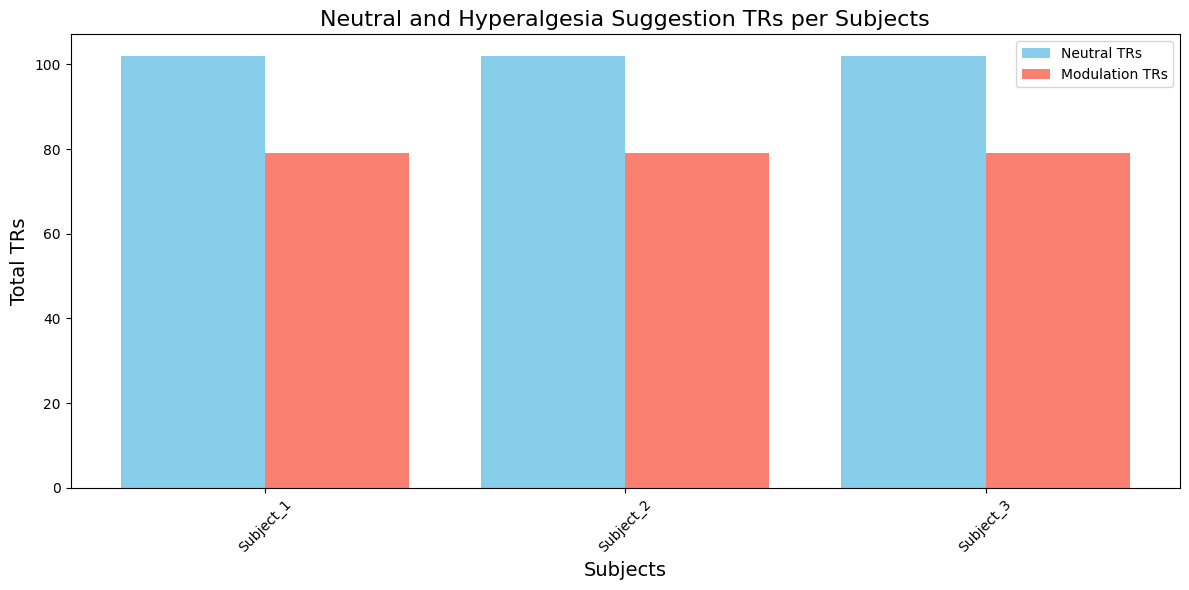

     Subject  Neutral_TRs  Modulation_TRs
0  Subject_1          102              82
1  Subject_2          102              82
2  Subject_3          102              82
All subjects have the same number of TRs for both conditions.


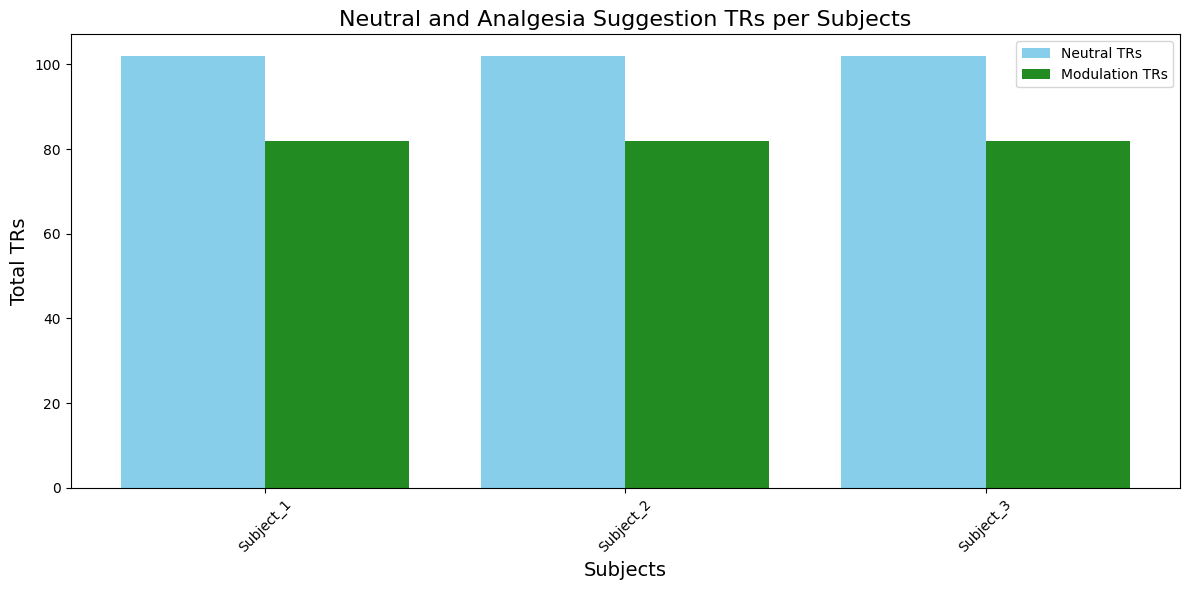

In [100]:
# saving in results/QC_TRs
save_path = os.path.join(project_dir, 'results', 'QC_TRs') 
os.makedirs(save_path, exist_ok=True)

#hyper condition
TRs_df, fig_hyper = count_TRs_2conds_general(
    events_hyper,
    TR=3,
    neutral_pattern="N_HYPER.*instrbk",
    modulation_pattern="HYPER.*instrbk",
    title='Neutral and Hyperalgesia Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="salmon",
    save_path = os.path.join(save_path, 'hyper-cond_TRs_allSubj.png')
)

plt.close(fig_hyper)

#Ana condition
TRs_df, fig_ana = count_TRs_2conds_general(
    events_ana,
    TR=3,
    neutral_pattern="N_ANA.*instrbk",
    modulation_pattern="ANA.*instrbk",
    title='Neutral and Analgesia Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="forestgreen",
    save_path = os.path.join(save_path, 'Ana-cond_TRs_allSubj.png')
)


plt.close(fig_ana)




### Desigm matrix

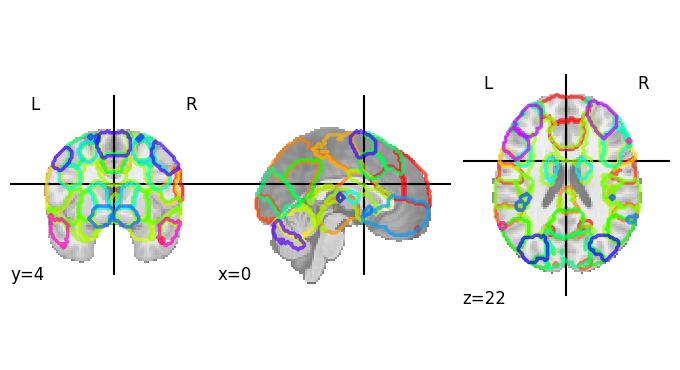

In [34]:
from nilearn.plotting import plot_prob_atlas

mask_nifti = mask_x.to_nifti()
view = plot_prob_atlas(mask_nifti, threshold=None)  # Use threshold=None to display the whole mask
view

**Extract data in ROI**

In [8]:
#func_ana = Brain_Data(ana_files)
n_subj = 6; # limit computation time

roi = 4
roi_mask = mask_x[roi]

#file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*nii.gz'))
ana_data = []
for count, (sub, f) in enumerate(zip(subjects, ana_files)):
    if count > n_subj:
        break
    else:    
        print(sub)
        data = Brain_Data(f)
        ana_data.append(data.apply_mask(roi_mask))

sub-09
sub-03
sub-22
sub-28
sub-17
sub-41
sub-36


**Hyper align**

In [11]:
ana_data

[nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)]

In [12]:
hyperalign = align(ana_data[:6], method='procrustes')

In [34]:
hyperalign

{'transformed': [nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)],
 'common_model': nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 'transformation_matrix': [nltools.data.brain_data.Brain_Data(data=(2786, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain

Text(0.5, 1.0, 'Aligned Voxel ISC: r=0.3')

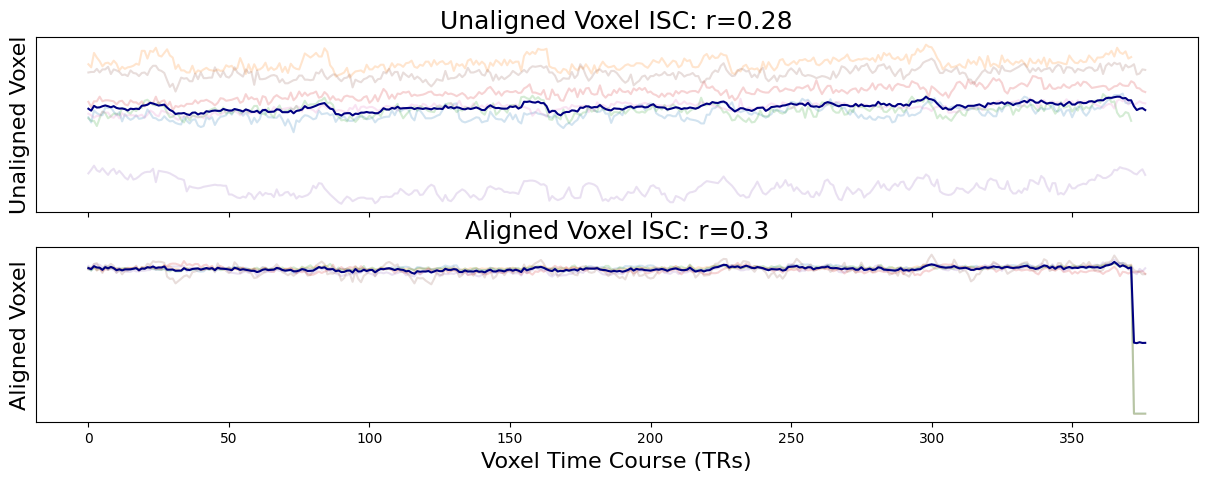

In [17]:
voxel_index = 50

voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in ana_data]).T # x is subject i
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)


**ISC distribution : N voxel pair-wise correlation, meaned**

Unaligned voxel ISC

In [22]:
ana_data[0].data.flatten().shape

(1036392,)

In [23]:
ana_data[0].data.shape[1]

2786

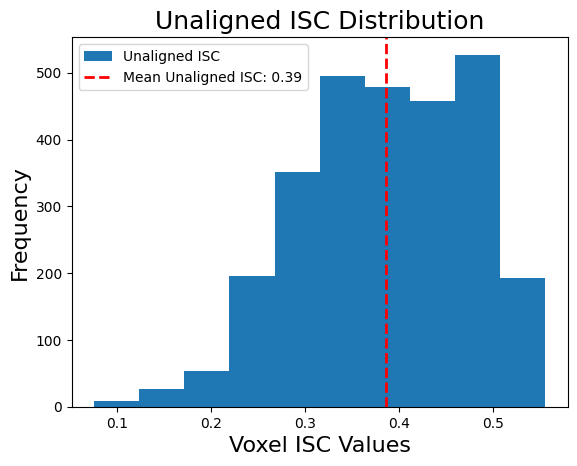

Mean Unaligned ISC (voxel-wise): 0.39


In [30]:
import numpy as np
from nltools.data import Adjacency

unaligned_isc = {}

#compute mean ISC for each unaligned voxel to plot distribution
for voxel_index in range(ana_data[0].data.shape[1]):  # Assuming all_data is a list of Brain_Data objects
    # Extract the time series for this voxel across all subjects
    voxel_time_series = np.array([x.data[:372, voxel_index] for x in ana_data])  # shape (n_subjects, n_timepoints)
    voxel_corr = np.corrcoef(voxel_time_series)  # matrix shape (n_subjects, n_subjects)
    triu_indices = np.triu_indices_from(voxel_corr, k=1) # mean of triangle
    unaligned_isc[voxel_index] = voxel_corr[triu_indices].mean()

plt.hist(unaligned_isc.values(),label='Unaligned ISC')
plt.axvline(x=np.mean(list(unaligned_isc.values())), linestyle='--', color='red', linewidth=2, label=f'Mean Unaligned ISC: {np.mean(list(unaligned_isc.values())):.2f}')
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Unaligned ISC Distribution', fontsize=18)
plt.legend()
plt.show()

# Print the mean ISC value for unaligned data
print(f"Mean Unaligned ISC (voxel-wise): {np.mean(list(unaligned_isc.values())):.2f}")


Mean ISC: 0.33


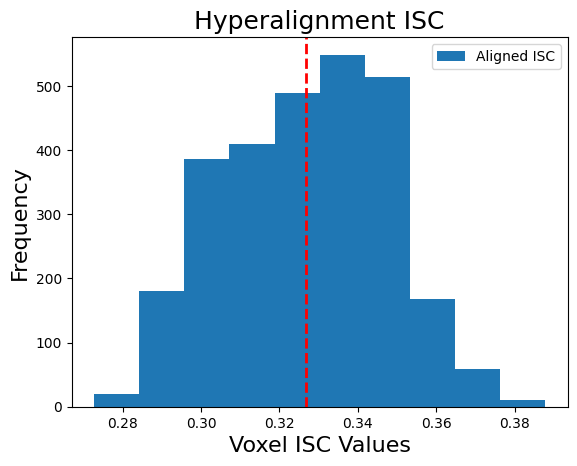

In [32]:
plt.hist(hyperalign['isc'].values(), label='Aligned ISC')
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.legend()
plt.title('Hyperalignment ISC', fontsize=18)

print(f"Mean ISC: {np.mean(list(hyperalign['isc'].values())):.2}")

**Compare a slice of ROI**

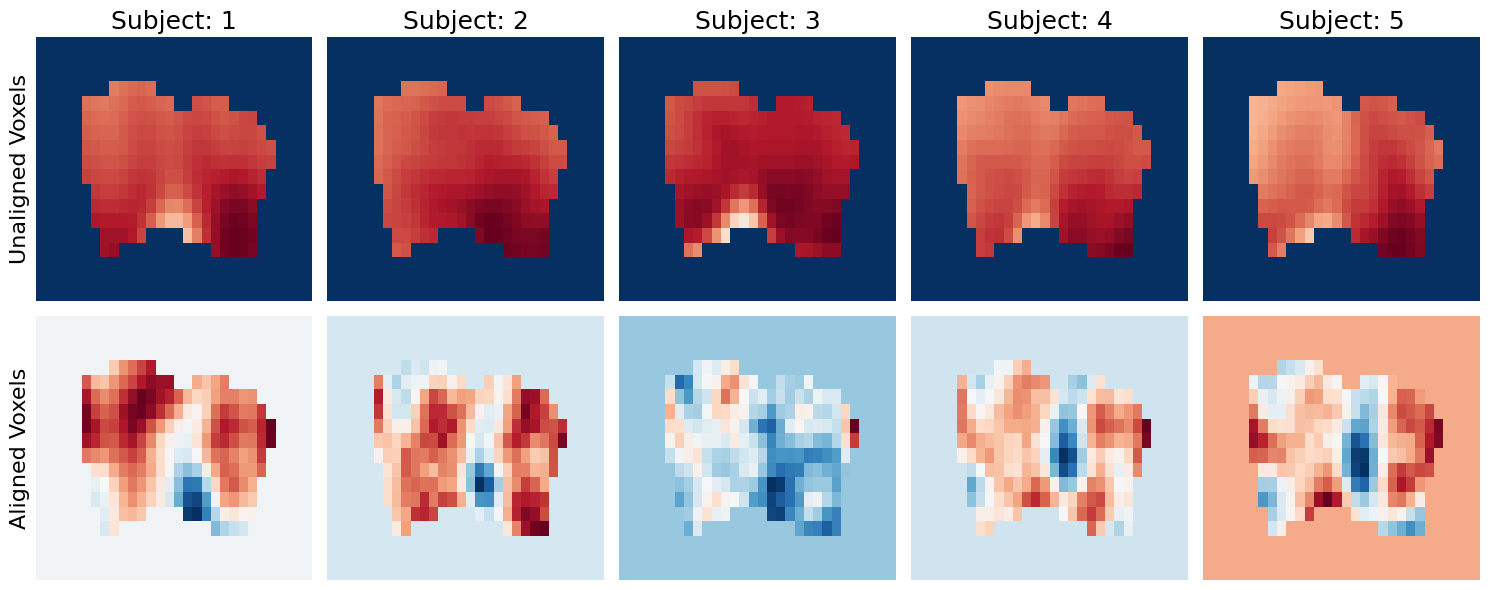

In [33]:
tr_index = 100

f,a = plt.subplots(ncols=5, nrows=2, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    sns.heatmap(np.rot90(ana_data[i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[0,i])
    a[0,i].set_title(f'Subject: {i+1}', fontsize=18)
    a[0,i].axes.get_xaxis().set_visible(False)
    a[0,i].yaxis.set_ticks([])
    sns.heatmap(np.rot90(hyperalign['transformed'][i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[1,i])
    a[1,i].axes.get_xaxis().set_visible(False)
    a[1,i].yaxis.set_ticks([])

a[0,0].set_ylabel('Unaligned Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Voxels', fontsize=16)

plt.tight_layout()

In [ ]:
data_dir = '/data/rainville/Hypnosis_ISC/4D_data/segmented'